In [4]:
## step 1) data cleaning ##

# import necessary tools:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

data = pd.read_csv("/workspaces/DS_project/Cleaned_Data/usa_with_snow.csv")

In [5]:
data["vertical"] = data["Highest point"] - data["Lowest point"]

In [6]:
data.columns

Index(['Resort', 'Country', 'Price', 'Season', 'Highest point', 'Lowest point',
       'Beginner slopes', 'Intermediate slopes', 'Difficult slopes',
       'Total slopes', 'Snow cannons', 'Total lifts', 'Lift capacity',
       'Snowparks', 'Nightskiing', 'latitude', 'longitude', 'Snow',
       'vertical'],
      dtype='object')

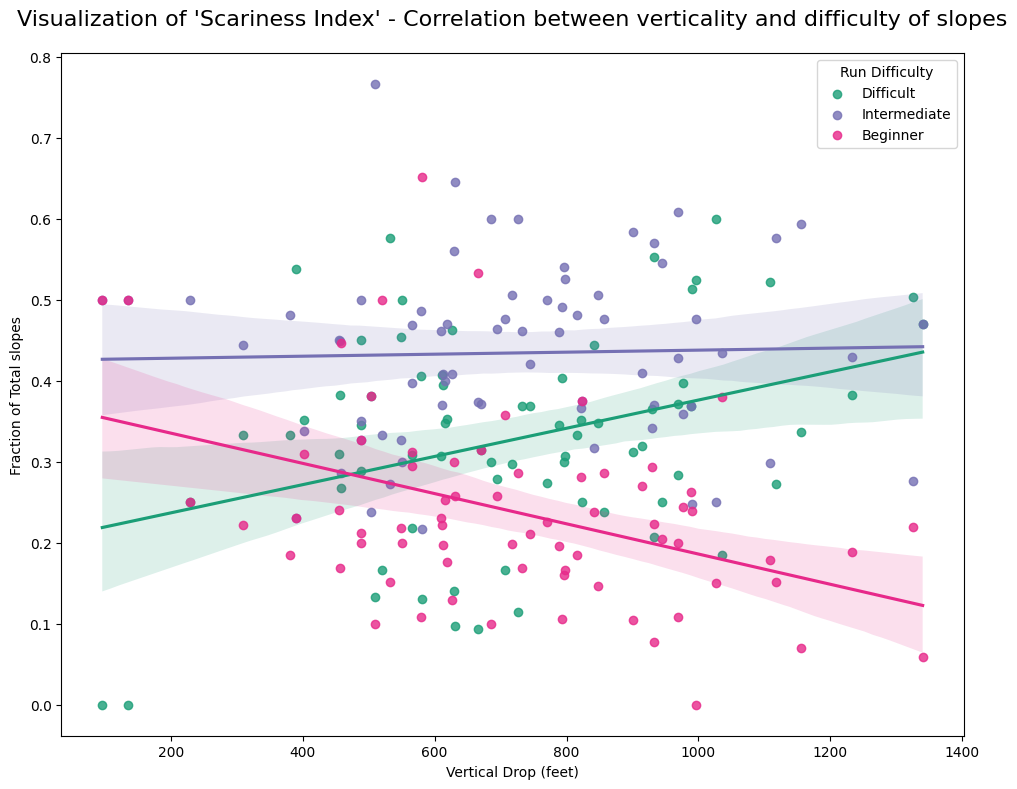

In [10]:
# Hmmm... Based on thata information, you might think, 
#   "That makes sense- of course places like Missouri and Wisconsin wouldn't have many expert slopes
#   while more mountainous places like Wyoming and Montana do."
# Do we see a relationship between how moutnainous a resort is and how difficult the slopes are?

 # dataframe for "difficulty"
diff = pd.DataFrame(index=data.index)
diff["Resort"] = data.get("Resort", data.index)
# add vertical to diff (ensure numeric)



# columns to use:
diff_cols = ["Beginner slopes", "Intermediate slopes", "Difficult slopes"]
total_col = "Total slopes"

# initialize diff with an index and identifier column
diff = pd.DataFrame(index=data.index)
diff["Resort"] = data.get("Resort", data.index)
diff["vertical"] = pd.to_numeric(data.get("vertical", pd.Series(index=data.index)), errors="coerce")
# add resort location/state to diff

for c in diff_cols:
    data[c] = pd.to_numeric(data[c].astype(str).str.replace(",", "", regex=False), errors="coerce")
    base_name = c.lower().replace(" ", "_")      # e.g. "beginner_slopes"
    frac_col = f"{base_name}_frac"               # fraction of total slopes

    diff[frac_col] = data[c] / data[total_col]

# handle infinite results and keep NaNs for missing/zero totals
diff.replace([np.inf, -np.inf], np.nan, inplace=True)


## "diff" is a dataframe containing the decimal fraction of different run difficulties
# verticality vs % difficult slopes (or what I'm calling: scariness index)
import scipy

plt.figure(figsize= (10,8))
col = sns.color_palette("Dark2", 4)
sc_in = sns.regplot(x = data["vertical"], y = diff["difficult_slopes_frac"], color = col[0], label = "Difficult")

sc_in_neg1 = sns.regplot(x = data["vertical"], y = diff["intermediate_slopes_frac"], color = col[2], label = "Intermediate")

sc_in_neg2 = sns.regplot(x = data["vertical"], y = diff["beginner_slopes_frac"], color = col[3], label = "Beginner")


# sc_in_comb = sns.regplot(x = data["vertical"], y = diff["advanced_slopes_frac"] + diff ["expert_slopes_frac"])
    # combined expert and advanceed slopes
plt.legend(title="Run Difficulty", loc='best')
plt.xlabel("Vertical Drop (feet)")
plt.ylabel("Fraction of Total slopes")
plt.title("Visualization of 'Scariness Index' - " \
"Correlation between verticality and difficulty of slopes", 
          fontsize = 16, pad = 20)

plt.tight_layout()
plt.show()
# this plot shows how the % of run difficulty is related to the verticality (slope) of the resort
    # the most positive slope is expert, and the most negative is beginner, which makes sense!

In [11]:
diff.columns

Index(['Resort', 'vertical', 'beginner_slopes_frac',
       'intermediate_slopes_frac', 'difficult_slopes_frac'],
      dtype='object')

In [13]:

# Okay since there's a relationship, I would consider resorts with steep AND difficult slopes "scarier" than those with little verticality and easier slopes.
    # Therefore, let's assign each resort a "Scariness Index" as a function of a "difficulty score" * vertical
    # (difficulty score is a weighted sum of the % of slopes of each difficulty level)
## calculating a "Scariness Index"
Resort_diff_byFrac = diff[["Resort", "vertical", "beginner_slopes_frac", "intermediate_slopes_frac", "difficult_slopes_frac"]]
Resort_diff_byFrac.head()

cols = ["Beginner slopes", "Intermediate slopes", "Difficult slopes"]

# assign weights to difficulties
weights = {"beginner_slopes_frac": 1, "intermediate_slopes_frac": 2, "difficult_slopes_frac": 3}


# loop for calculating a difficulty score (weighted sum of each resort)
for idx, row in Resort_diff_byFrac.iterrows():
    score = 0.0
    for col, w in weights.items():
        v = row.get(col, 0)
        # skip when value is 0 so scores aren't 0 from multiplicaiton
        if pd.isna(v) or v == 0:
            continue
        score += float(v) * w
    Resort_diff_byFrac.at[idx, "difficulty_score_byFrac"] = score

## calculate "scariness index" value ##
    # defined as "difficulty score" * "vertical"
Resort_diff_byFrac["ScarinessIndex"] = Resort_diff_byFrac["vertical"]*Resort_diff_byFrac["difficulty_score_byFrac"]
Resort_diff_byFrac.head()

,Resort,vertical,beginner_slopes_frac,intermediate_slopes_frac,difficult_slopes_frac,difficulty_score_byFrac,ScarinessIndex
0,Steamboat,1118,0.151515,0.575758,0.272727,2.121212,2371.515152
1,Howelsen Hill-Steamboat Springs,135,0.500000,0.500000,0.000000,1.500000,202.500000
2,Crested Butte,933,0.223140,0.570248,0.206612,1.983471,1850.578512
3,Park City,969,0.108000,0.608000,0.284000,2.176000,2108.544000
4,Arapahoe Basin,504,0.380952,0.238095,0.380952,2.000000,1008.000000


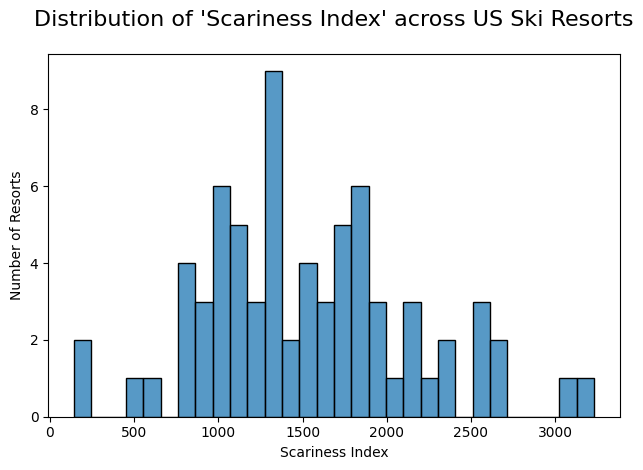

In [14]:
sns.histplot(Resort_diff_byFrac["ScarinessIndex"].dropna(), bins=30)
plt.title("Distribution of 'Scariness Index' across US Ski Resorts", fontsize=16, pad=20)
plt.xlabel("Scariness Index")
plt.ylabel("Number of Resorts")
plt.tight_layout()
plt.show()

Regression stats: slope=498.62640057246347, intercept=-320.0162643222834, rvalue=0.42413775286893446, pvalue=0.00022776494267022675, stderr=128.16784914277946


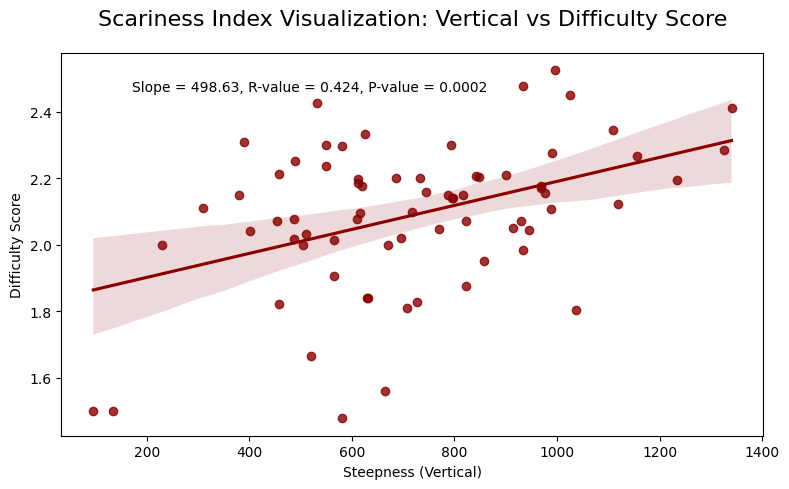

In [19]:
# visualizing scariness via regression plot:
fig2 = plt.figure(figsize= (8, 5))
sns.regplot(data = Resort_diff_byFrac, x = "vertical", y = "difficulty_score_byFrac", color = "DarkRed")
plt.title("Scariness Index Visualization: Vertical vs Difficulty Score", fontsize = 16, pad = 20)
plt.xlabel("Steepness (Vertical)")
plt.ylabel("Difficulty Score")
stats = scipy.stats.linregress(Resort_diff_byFrac["difficulty_score_byFrac"], Resort_diff_byFrac["vertical"])
print(f"Regression stats: slope={stats.slope}, intercept={stats.intercept}, rvalue={stats.rvalue}, pvalue={stats.pvalue}, stderr={stats.stderr}")
plt.annotate("Slope = 498.63, R-value = 0.424, P-value = 0.0002", xy=(0.1, 0.9), xycoords='axes fraction')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize = (10,7))
US_Prices["Season Pass Adult"] = US_Prices["Season Pass Adult"].dropna().astype("float64")
US_Prices["Days Open This Season"] = US_Prices["Days Open This Season"].dropna().astype("Int64")
sns.regplot(data = US_Prices, x = "Season Pass Adult", y = "Days Open This Season", color="DarkRed")
scipy.stats.linregress(US_Prices["Season Pass Adult"], US_Prices["Days Open This Season"])
print(scipy.stats.linregress(US_Prices["Season Pass Adult"], US_Prices["Days Open This Season"]))
plt.title("Season Length vs Adult Season Pass Price", fontsize = 16, pad = 20)
plt.xlabel("Adult Season Pass Price (USD)")
plt.ylabel("Recent Season Length (Days)")
# plt.annotate("Slope = 1635.69, P-value = 0.0006", xy=(0.1, 0.9), xycoords='axes fraction') --> stats aren't working :(
plt.tight_layout()
plt.show()
